In [16]:
import os,torch
import torch.nn.functional as tf
from torch import nn
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from vis_utils import show_img_batch
%matplotlib inline

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
mnist = MNIST(root="../Data/", download=False, 
              transform=transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize((0.5,), (0.5,))]))
mnist_dl = DataLoader(mnist, batch_size=128, shuffle=True)

In [4]:
class GenConvTransposeBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, final=False):
        super().__init__()
        if not final:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_channels, 
                                   out_channels=out_channels, 
                                   kernel_size=kernel_size,
                                   stride=stride),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_channels, 
                                   out_channels=out_channels, 
                                   kernel_size= kernel_size, 
                                   stride=stride),
                nn.Tanh()
            )

    def forward(self, x):
        return self.block(x)

In [5]:
class Generator(nn.Module):

    def __init__(self, z_dim, im_chan=1, hidden_dim=64):
        super().__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            GenConvTransposeBlock(z_dim, hidden_dim * 4),
            GenConvTransposeBlock(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            GenConvTransposeBlock(hidden_dim * 2, hidden_dim * 1),
            GenConvTransposeBlock(hidden_dim * 1, im_chan,  kernel_size=4, final=True)
        )

    def unsqueeze_noise(self, x):
        return x.view(len(x), self.z_dim, 1, 1)
    
    def forward(self, x):
        x = self.unsqueeze_noise(x)
        return self.gen(x)

In [6]:
def get_noise(n_samples, z_dim, device):
    return torch.randn((n_samples, z_dim), device=device)

In [7]:
class DiscConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, final=False):
        super().__init__()
        if not final:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, 
                          out_channels=out_channels, 
                          kernel_size=kernel_size,
                          stride=stride),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, 
                          out_channels=out_channels, 
                          kernel_size= kernel_size, 
                          stride=stride),
            )

    def forward(self, x):
        return self.block(x)

In [8]:
class Discriminator(nn.Module):

    def __init__(self, im_chan, hidden_dim=64):
        super().__init__()
        self.disc = nn.Sequential(
            DiscConvBlock(im_chan, hidden_dim * 1),
            DiscConvBlock(hidden_dim * 1, hidden_dim * 2),
            DiscConvBlock(hidden_dim * 2, 1, final=True),
        )

    def forward(self, x):
        return self.disc(x).view(-1, 1)

In [58]:
def combine_tensors(x, y):
    return torch.concat((x,y), dim=1)

In [54]:
n_samples = 128
z_dim = 10
hidden_dim = 64
noise_input = get_noise(n_samples, z_dim, device)
real, labels = next(iter(mnist_dl))
gen = Generator(z_dim=z_dim, im_chan=1, hidden_dim=64).to(device)
fake = gen(noise_input)
disc = Discriminator(1, 64).to(device)

In [55]:
# Get one-hot encoded labels using torch function
labels = labels.to(device)
one_hot = tf.one_hot(labels, num_classes=10)
# Expand one-hot to 4D by adding height/width dims and repeating values
expanded_onehot = one_hot[:,:,None,None].expand(-1, -1, 28, 28)


In [56]:
mnist_shape = (1, 28, 28)
n_classes = 10

criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 5000
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002


beta_1 = 0.5 
beta_2 = 0.999

In [64]:
# Initialize the generator and discriminator
gen = Generator(z_dim=z_dim+n_classes).to(device)
disc = Discriminator(im_chan=1+n_classes).to(device)

# Initialize the optimizers for generator and discriminator
gen_opt = torch.optim.Adam(gen.parameters(),   lr=lr, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

 66%|██████▌   | 310/469 [00:17<00:08, 17.88it/s]

Epoch 10, step 5000: Generator loss: 1.26, discriminator loss: 0.51


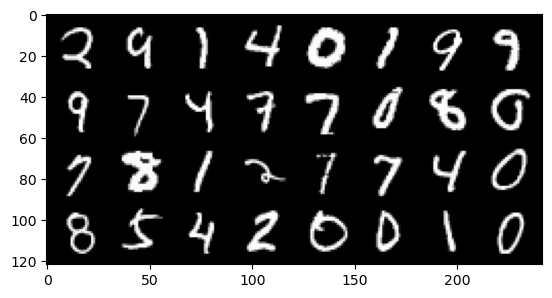

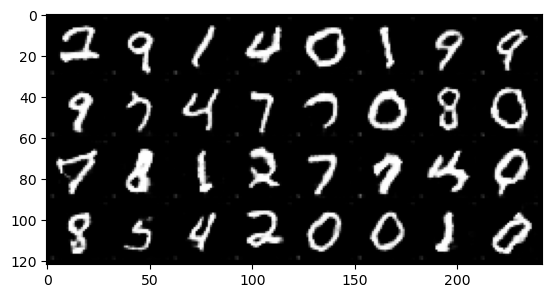

 32%|███▏      | 150/469 [00:08<00:17, 18.02it/s]

Epoch 21, step 10000: Generator loss: 0.83, discriminator loss: 0.65


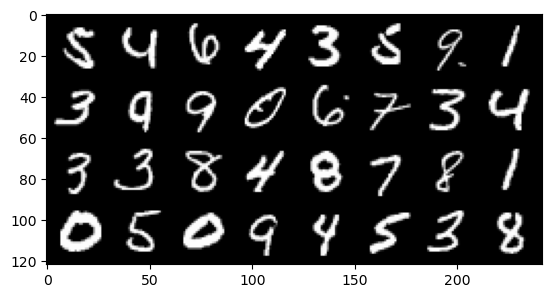

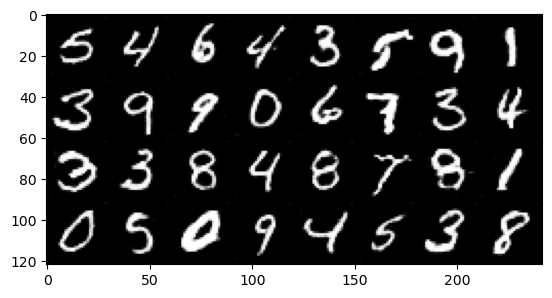

 98%|█████████▊| 460/469 [00:25<00:00, 17.85it/s]

Epoch 31, step 15000: Generator loss: 0.80, discriminator loss: 0.66


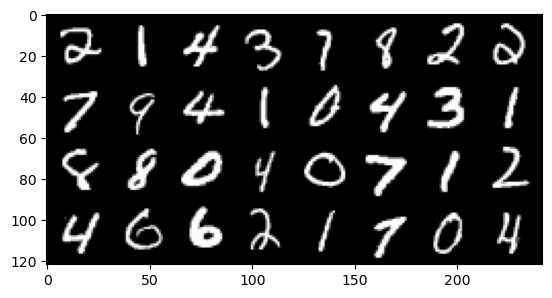

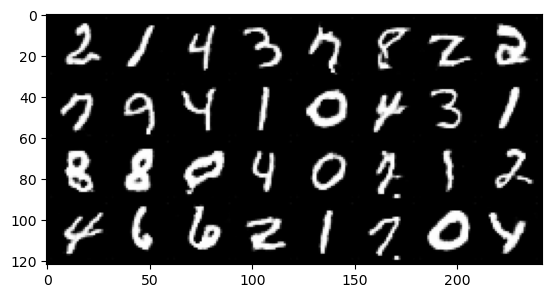

 64%|██████▍   | 302/469 [00:17<00:09, 17.79it/s]

Epoch 42, step 20000: Generator loss: 0.80, discriminator loss: 0.66


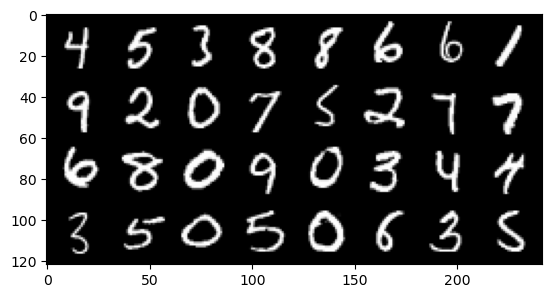

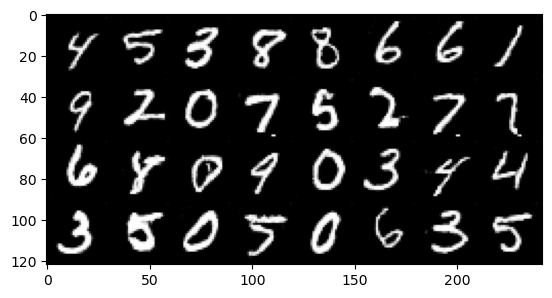

 30%|███       | 141/469 [00:05<00:12, 25.42it/s]

Epoch 53, step 25000: Generator loss: 0.79, discriminator loss: 0.66


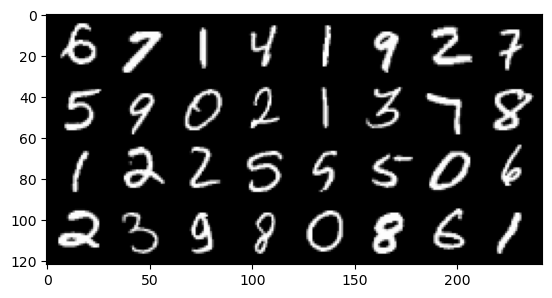

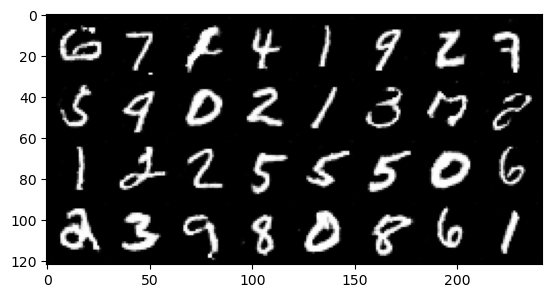

 97%|█████████▋| 453/469 [00:18<00:00, 25.25it/s]

Epoch 63, step 30000: Generator loss: 0.78, discriminator loss: 0.67


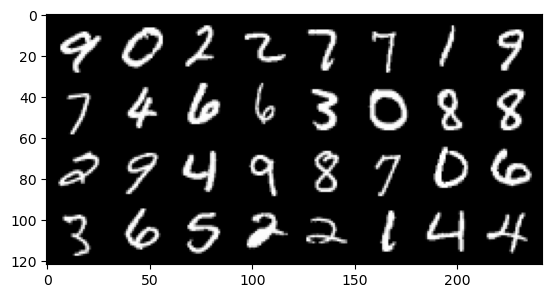

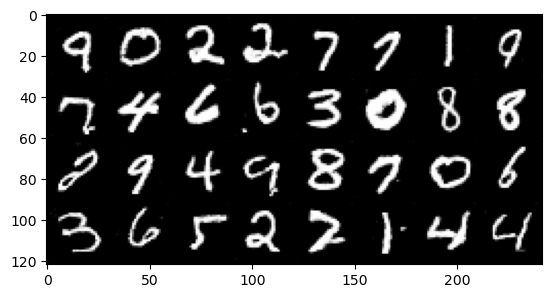

 63%|██████▎   | 294/469 [00:11<00:06, 25.24it/s]

Epoch 74, step 35000: Generator loss: 0.77, discriminator loss: 0.67


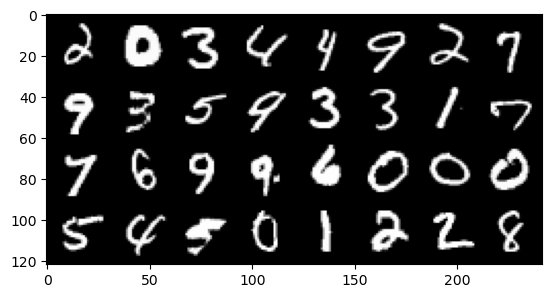

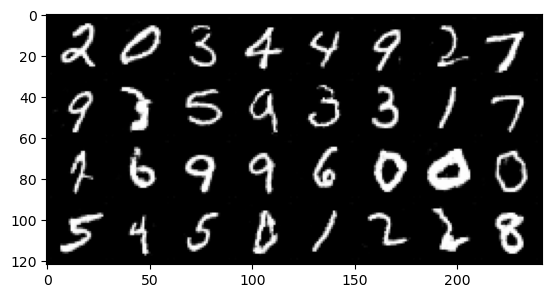

 29%|██▉       | 135/469 [00:05<00:13, 25.34it/s]

Epoch 85, step 40000: Generator loss: 0.76, discriminator loss: 0.68


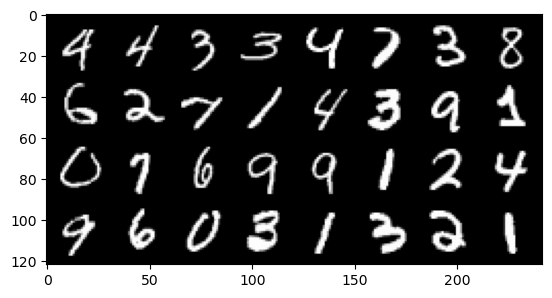

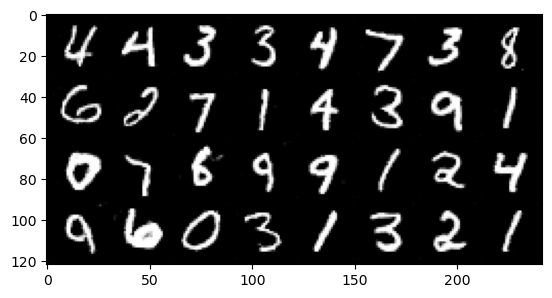

 95%|█████████▍| 444/469 [00:17<00:00, 25.44it/s]

Epoch 95, step 45000: Generator loss: 0.76, discriminator loss: 0.68


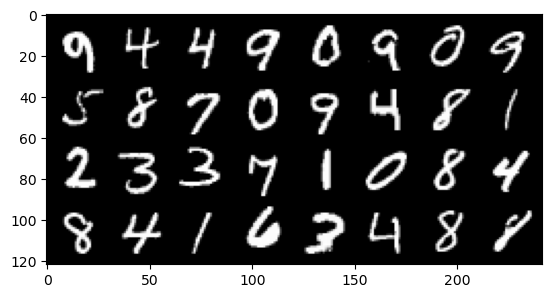

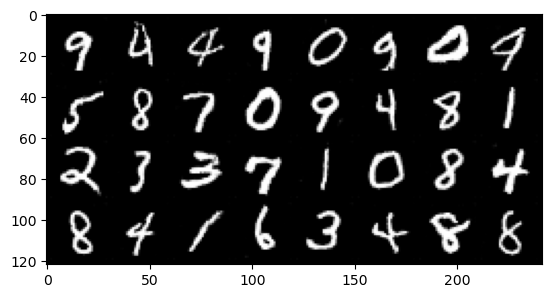

100%|██████████| 469/469 [00:26<00:00, 17.82it/s]


In [65]:
n_epochs = 100
cur_step = 0
generator_loss = 0
discriminator_loss = 0

for epoch in range(n_epochs):

    for real, labels in tqdm(mnist_dl):
        cur_batch_size = len(real)
        real = real.to(device)
        
        one_hot_vec = tf.one_hot(labels.to(device), num_classes=10)
        one_hot_img = one_hot_vec[:,:,None,None].expand(-1, -1, 28, 28)

        ## Update discriminator ##
        disc_opt.zero_grad()
        
        # Get noise corresponding to the current batch_size
        noise = get_noise(cur_batch_size, z_dim, device=device)
        
        fake = gen(combine_tensors(noise, one_hot_vec))
        fake_comb = combine_tensors(fake, one_hot_img)
        disc_fake = disc(fake_comb.detach())
        disc_fake_loss = criterion(disc_fake, torch.zeros_like(disc_fake, device=device))


        real_comb = combine_tensors(real, one_hot_img)
        disc_real = disc(real_comb)
        disc_real_loss = criterion(disc_real, torch.ones_like(disc_fake, device=device))
        disc_loss = (disc_real_loss + disc_fake_loss) / 2

        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        discriminator_loss += disc_loss.item()
        
        ### Update generator ###
        gen_opt.zero_grad()
        noise = get_noise(cur_batch_size, z_dim, device=device)
                
        fake = gen(combine_tensors(noise, one_hot_vec))
        fake_comb = combine_tensors(fake, one_hot_img)
        gen_fake = disc(fake_comb)
        gen_fake_loss = criterion(gen_fake, torch.ones_like(gen_fake, device=device))
        gen_fake_loss.backward()
        gen_opt.step()        
        
        # Keep track of the average generator loss
        generator_loss += gen_fake_loss.item()

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            mean_gen_loss = generator_loss/display_step
            mean_disc_loss = discriminator_loss/display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_gen_loss:.2f}, discriminator loss: {mean_disc_loss:.2f}")
            generator_loss = 0
            discriminator_loss = 0
            show_img_batch((real + 1) / 2)
            show_img_batch((fake + 1) / 2)
        cur_step += 1


In [66]:
torch.save({'generator': gen.state_dict(), 
            'discriminator': disc.state_dict(), 
            'gen_opt': gen_opt.state_dict(), 
            'disc_opt': disc_opt.state_dict()
            }, 
            'cgan_models.pth')



In [106]:
models = torch.load('cgan_models.pth')
gen_loaded = Generator(z_dim=z_dim+n_classes).to(device)
disc_loaded = Discriminator(im_chan=1+n_classes).to(device)
gen_loaded.load_state_dict(models['generator'])
disc_loaded.load_state_dict(models['discriminator']) 

/var/folders/v0/7qsx_21d0qj1gh5gtygr9yzw0000gn/T/ipykernel_66276/1696886759.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models = torch.load('cgan_models.pth')


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


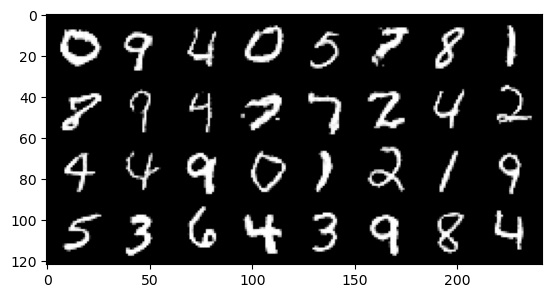

In [118]:
noise = get_noise(32, z_dim, device)
labels_ = torch.randint(0, 10, (32, ), device=device)
one_hot_vec = tf.one_hot(labels_, num_classes=10)
gen_input = combine_tensors(noise, one_hot_vec)
show_img_batch(gen_loaded(gen_input))